In [1]:
import os
import fnmatch
import pandas as pd
import pickle as pk
from multiprocessing import Pool
import workers
import time

Dataset_location= "C:/Users/Admin/Desktop/Dataset/uber-pickups-in-new-york-city"

### Get all files's location

In [2]:
def get_file_location(folder_location):
    file_list= []
    for filename in os.listdir(folder_location):
        if fnmatch.fnmatch(filename, 'uber-raw-data-*14.csv'):
            full_path= os.path.join(folder_location,filename)
            file_list.append(full_path)
    return(file_list)

In [3]:
# Create a workers.py module in the same folder with the following code
# def read_csv_to_datetime(file):
#     monthly_data= pd.read_csv(file,delimiter=",",header=0)
#     monthly_data["Date/Time"]=pd.to_datetime(monthly_data["Date/Time"])
#     return monthly_data
# The purpose of this is to run the multiprocessing read and merge csv file

### Run multiprocessing to faster the process of reading multiple files


In [4]:
if __name__=="__main__":
    
    print("Start")
    start= time.time()
    list_of_files= get_file_location(Dataset_location)
    pool= Pool(processes=4)
    df= pool.map(workers.read_csv_to_datetime,list_of_files)
    end= time.time()
    print("End")
    print("Total merge time: ",end-start, " seconds")
    

Start
End
Total merge time:  151.0616316795349  seconds


### Merge data of all months into one

In [5]:
new_df= pd.DataFrame()
for data in df:
    new_df= pd.concat([data, new_df])

In [6]:
df= new_df
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4534327 entries, 0 to 564515
Data columns (total 4 columns):
Date/Time    datetime64[ns]
Lat          float64
Lon          float64
Base         object
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 173.0+ MB


### Add some usefull columns for analyzing

In [7]:
def get_dom(dt):
    return dt.day

def get_weekday(dt):
    return dt.weekday()

def get_hour(dt):
    return dt.hour

def get_month(dt):
    return dt.month


df['Day_of_month']= df["Date/Time"].map(get_dom)

df['weekday']= df["Date/Time"].map(get_weekday)

df['Hour']= df["Date/Time"].map(get_hour)

df["Month"]= df["Date/Time"].map(get_month)


In [8]:
df.head(10)

,Date/Time,Lat,Lon,Base,Day_of_month,weekday,Hour,Month
0,2014-09-01 00:01:00,40.2201,-74.0021,B02512,1,0,0,9
1,2014-09-01 00:01:00,40.7500,-74.0027,B02512,1,0,0,9
2,2014-09-01 00:03:00,40.7559,-73.9864,B02512,1,0,0,9
3,2014-09-01 00:06:00,40.7450,-73.9889,B02512,1,0,0,9
4,2014-09-01 00:11:00,40.8145,-73.9444,B02512,1,0,0,9
5,2014-09-01 00:12:00,40.6735,-73.9918,B02512,1,0,0,9
6,2014-09-01 00:15:00,40.7471,-73.6472,B02512,1,0,0,9
7,2014-09-01 00:16:00,40.6613,-74.2691,B02512,1,0,0,9
8,2014-09-01 00:32:00,40.3745,-73.9999,B02512,1,0,0,9
9,2014-09-01 00:33:00,40.7633,-73.9773,B02512,1,0,0,9


## Analyzing data

In [9]:
%pylab inline
import seaborn as sns
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [61]:
by_date = df.groupby(["Month","Day_of_month"]).size().reset_index(name="Count")
by_date.head(10)


,Month,Day_of_month,Count
0,4,1,14546
1,4,2,17474
2,4,3,20701
3,4,4,26714
4,4,5,19521
5,4,6,13445
6,4,7,19550
7,4,8,16188
8,4,9,16843
9,4,10,20041


In [40]:
def Cumulative(data_frame, value_column, time_column):
    additional_column= []
    for index, count in data_frame[value_column].items():
        if index!=0:
            if by_date[time_column][index]==by_date[time_column][index-1]:
                    additional_column.append(additional_column[-1]+count)
            else:
                additional_column.append(count)
        else:
            additional_column.append(count)
    return additional_column


In [55]:
cumulative= Cumulative(by_date,"Count","Month") 


by_date["Cumulative"]= cumulative
by_date.head(10)

,Month,Day_of_month,Count,Cumulative
0,4,1,14546,14546
1,4,2,17474,32020
2,4,3,20701,52721
3,4,4,26714,79435
4,4,5,19521,98956
5,4,6,13445,112401
6,4,7,19550,131951
7,4,8,16188,148139
8,4,9,16843,164982
9,4,10,20041,185023


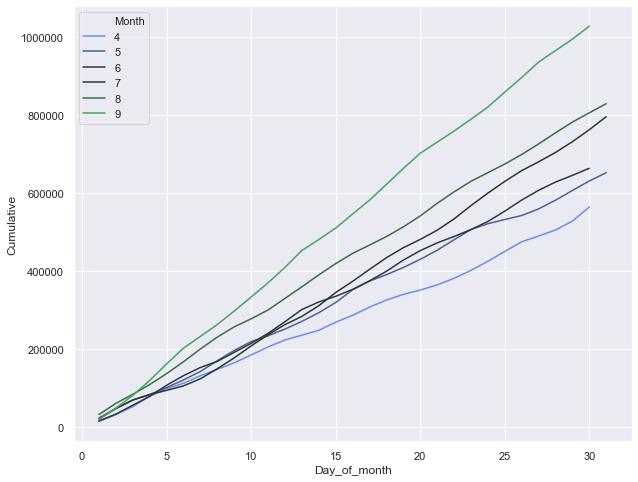

In [42]:
plt.figure(figsize=(10,8))
sns.lineplot(x="Day_of_month", y="Cumulative", hue="Month", data=by_date, palette =sns.diverging_palette(255, 133, l=60, n=6, center="dark"));

In [14]:
def count_rows(rows):
    return len(rows)

by_date_2= df.groupby("Day_of_month").apply(count_rows)

by_date_2.head(10)

Day_of_month
1     127430
2     143201
3     142983
4     140923
5     147054
6     139886
7     143503
8     145984
9     155135
10    152500
dtype: int64

Text(0.5, 1.0, 'Frequency by DoM - uber - Apr 2014')

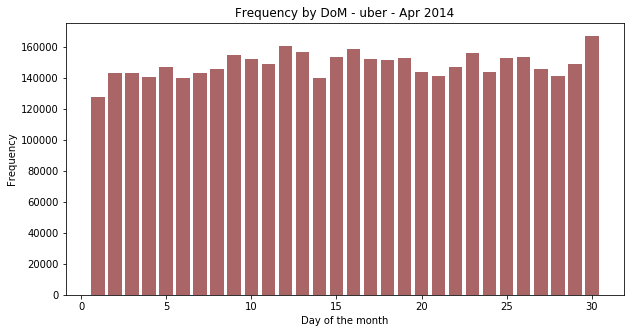

In [15]:
plt.figure(figsize=(10,5))
hist(df["Day_of_month"], bins=30, rwidth=.8, range=(0.5, 30.5),color='#AA6666')
xlabel('Day of the month')
ylabel('Frequency')
title('Frequency by DoM - uber - Apr 2014')

In [16]:
by_date_2_sorted = by_date_2.sort_values()


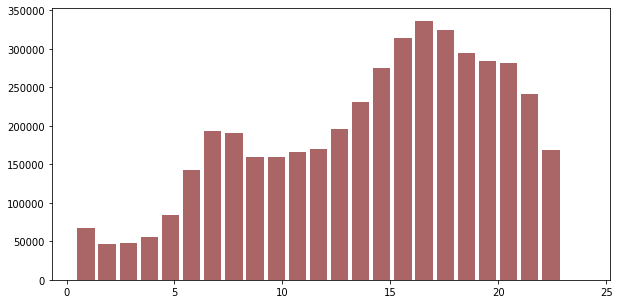

In [17]:
plt.figure(figsize=(10,5))
hist(df.Hour, bins=24, range=(0.5, 24), width=0.8,color='#AA6666');

In [48]:
by_cross = df.groupby('weekday Hour'.split()).apply(count_rows).unstack()
by_cross.head(10)

Hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
weekday,,,,,,,,,,,,,,,,,,,,,
0,6436,3737,2938,6232,9640,15032,23746,31159,29265,22197,...,28157,32744,38770,42023,37000,34159,32849,28925,20158,11811
1,6237,3509,2571,4494,7548,14241,26872,36599,33934,25023,...,34846,41338,48667,55500,50186,44789,44661,39913,27712,14869
2,7644,4324,3141,4855,7511,13794,26943,36495,33826,25635,...,35148,43388,50684,55637,52732,47017,47772,44553,32868,18146
3,9293,5290,3719,5637,8505,14169,27065,37038,35431,27812,...,36699,44442,50560,56704,55825,51907,51990,51953,44194,27764
4,13716,8163,5350,6930,8806,13450,23412,32061,31509,25230,...,36206,43673,48169,51961,54762,49595,43542,48323,49409,41260
5,27633,19189,12710,9542,6846,7084,8579,11014,14411,17669,...,31418,38769,43512,42844,45883,41098,38714,43826,47951,43174
6,32877,23015,15436,10597,6374,6169,6596,8728,12128,16401,...,28151,31112,33038,31521,28291,25948,25076,23967,19566,12166


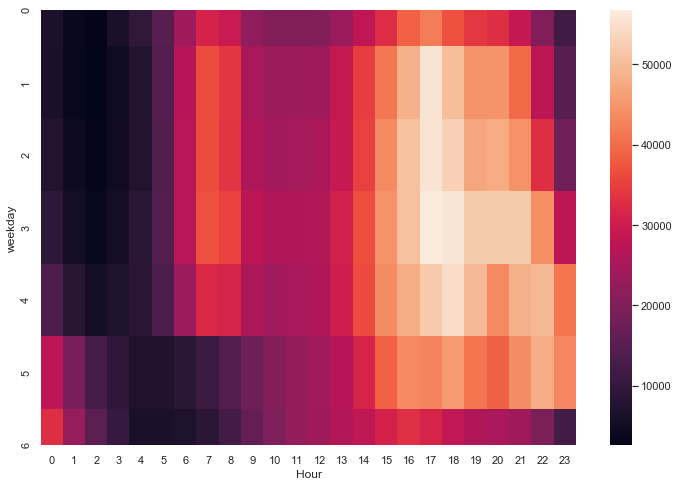

In [49]:
plt.figure(figsize=(12,8))
sns.heatmap(by_cross);

In [21]:
by_cross_2 = df.groupby('weekday Month'.split()).apply(count_rows).unstack()
by_cross_2.head(10)

Month,4,5,6,7,8,9
weekday,,,,,,
0,60861,63846,94655,93189,91633,137288
1,91185,76662,88134,137454,107124,163230
2,108631,89857,99654,147717,115256,135373
3,85067,128921,115325,148439,124117,153276
4,90303,133991,105056,102735,148674,160380
5,77218,102990,81364,90260,132225,162057
6,51251,56168,79656,76327,110246,116532


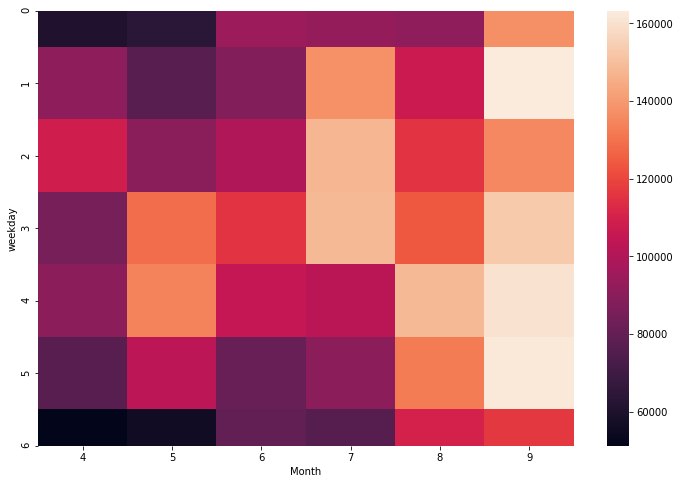

In [22]:
plt.figure(figsize=(12,8))
sns.heatmap(by_cross_2);

(40.55, 40.9)

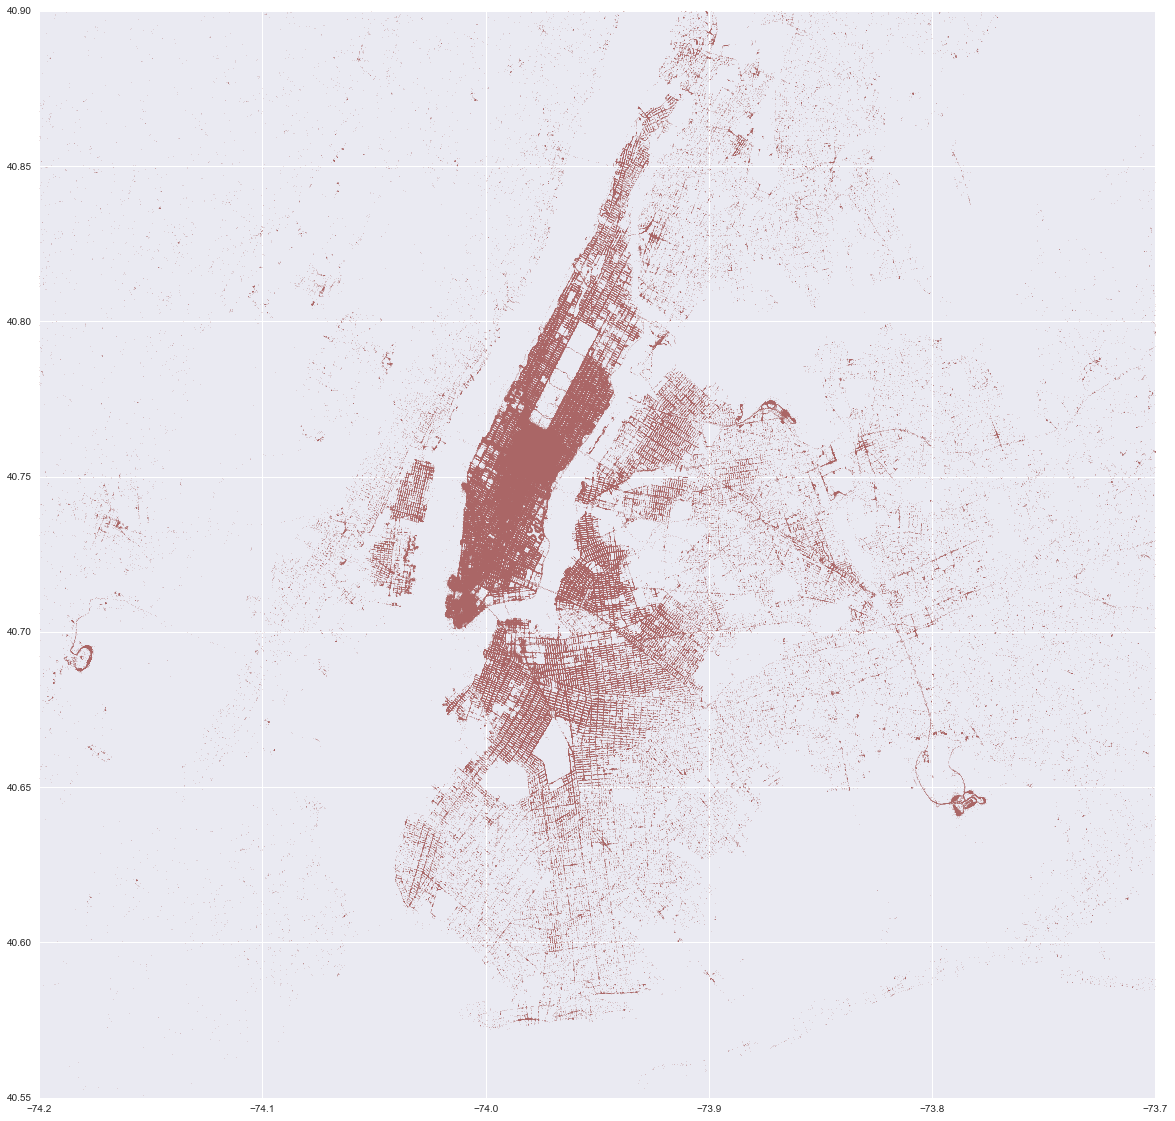

In [70]:
figure(figsize=(20, 20))
plot(df['Lon'], df['Lat'], '.', ms=1, color='#AA6666',alpha=.5)
xlim(-74.2, -73.7)
ylim(40.55, 40.9)